In [57]:
from pyquantum.circuit.circuit import Circuit
from pyquantum.circuit.sketch import Sketch

# 1 - Utilisation de l'objet Sketch

La classe `Sketch` permet de tracer des circuits simplement. Pour exemple, soit l'objet de type Sketch agissant sur 1 Qubit et de longueur 1. Sur le seul emplacement disponible, on affiche un carré de couleur `orchid`.

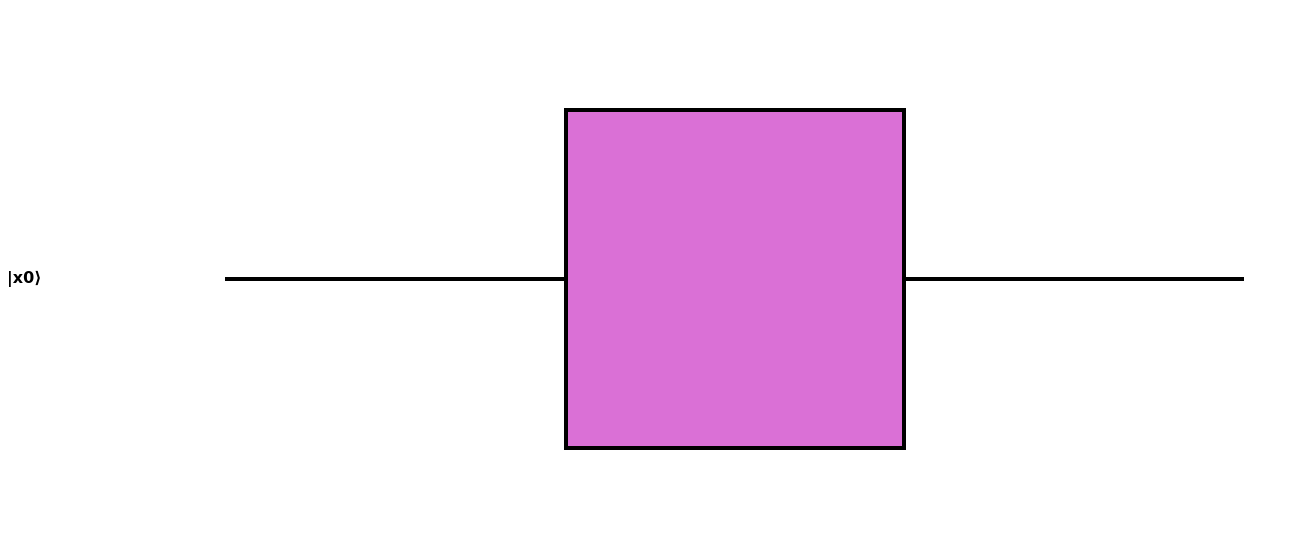

In [58]:
with Sketch(n_qubits=1, length=1) as s:
    s.add_square(0, 0, 'orchid')

On peut également simuler une porte controlée. Ici, on crée un circuit de 2 Qubits et on applique une porte au premier Qubit avec pour contrôle le second Qubit.

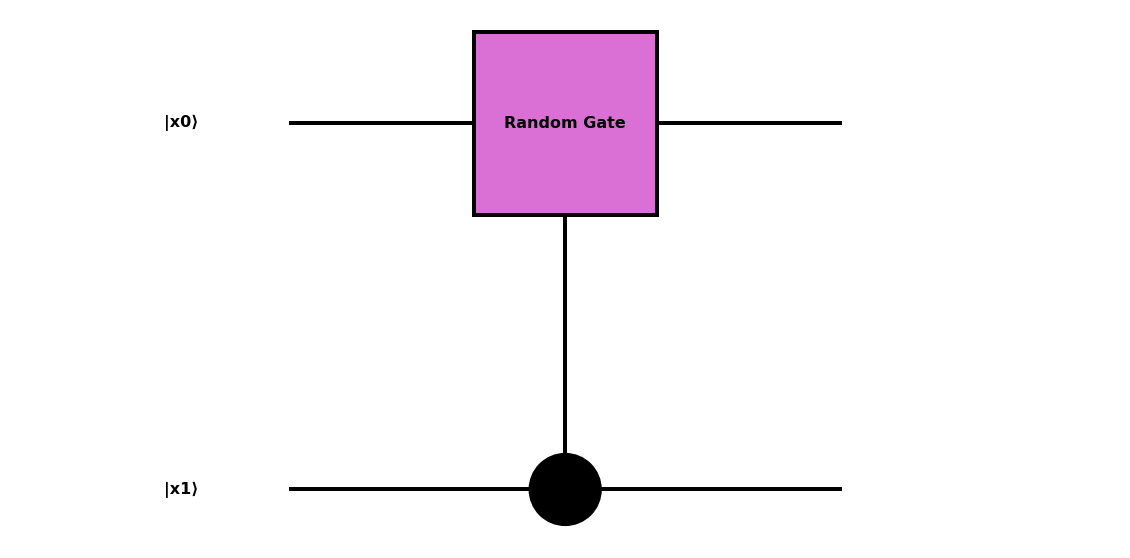

In [59]:
with Sketch(n_qubits=2, length=1) as s:
    s.add_square(0, 0, 'orchid')
    s.add_text(0, 0, 'Random Gate')
    s.add_circle(0, 1)
    s.add_vertical(0, [0, 1])

À partir de là, il est simple de construire un circuit un peu plus complexe et immédiatement reconnaissable visuellement.

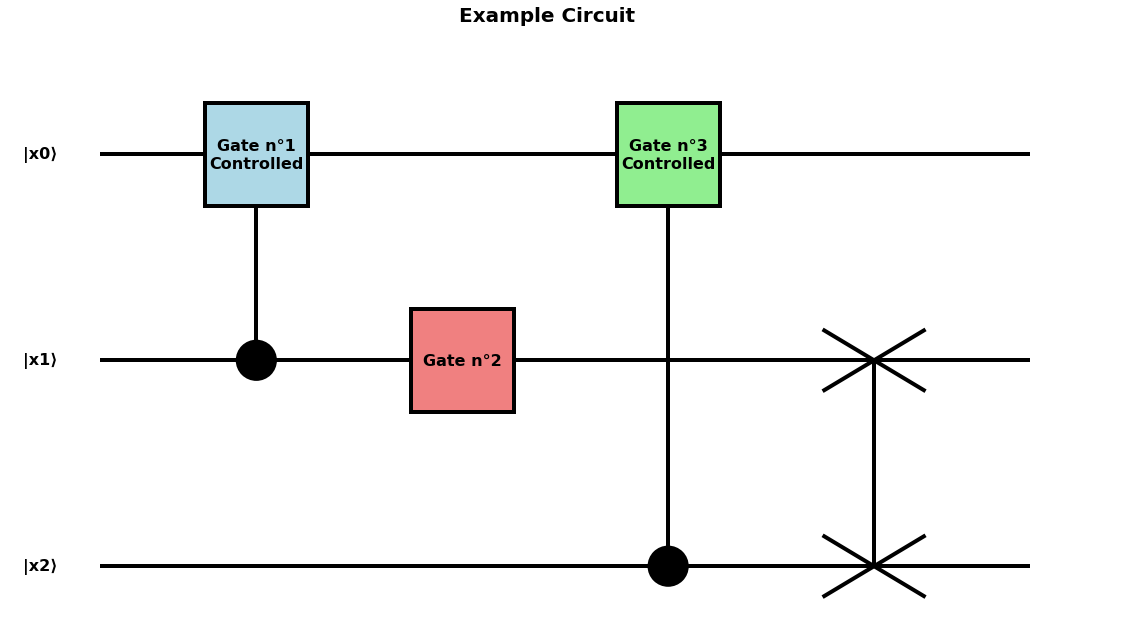

In [60]:
with Sketch(n_qubits=3, length=4, title='Example Circuit') as s:

    index, target, control = 0, 0, 1
    s.add_square(index=index, target=target, facecolor='lightblue')
    s.add_text(index=index, target=target, text='Gate n°1\nControlled')
    s.add_circle(index=index, target=control)
    s.add_vertical(index=index, targets=[control, target])

    index, target = 1, 1
    s.add_square(index=index, target=target, facecolor='lightcoral')
    s.add_text(index=index, target=target, text='Gate n°2')

    index, target, control = 2, 0, 2
    s.add_square(index=index, target=target, facecolor='lightgreen')
    s.add_text(index=index, target=target, text='Gate n°3\nControlled')
    s.add_circle(index=index, target=control)
    s.add_vertical(index=index, targets=[control, target])

    index, target, control = 3, 1, 2
    s.add_swap(index=index, targets=[control, target])

Le problème est que ces portes ne correspondent à rien, elles n'ont pas de représentation matricielle sous-jacente.

# 2 - Simulation d'un vrai circuit

Grâce aux portes contenues dans la classe `Sketch`, on peut simuler le circuit correspondant à la transormée de Fourier quantique pour deux Qubits.

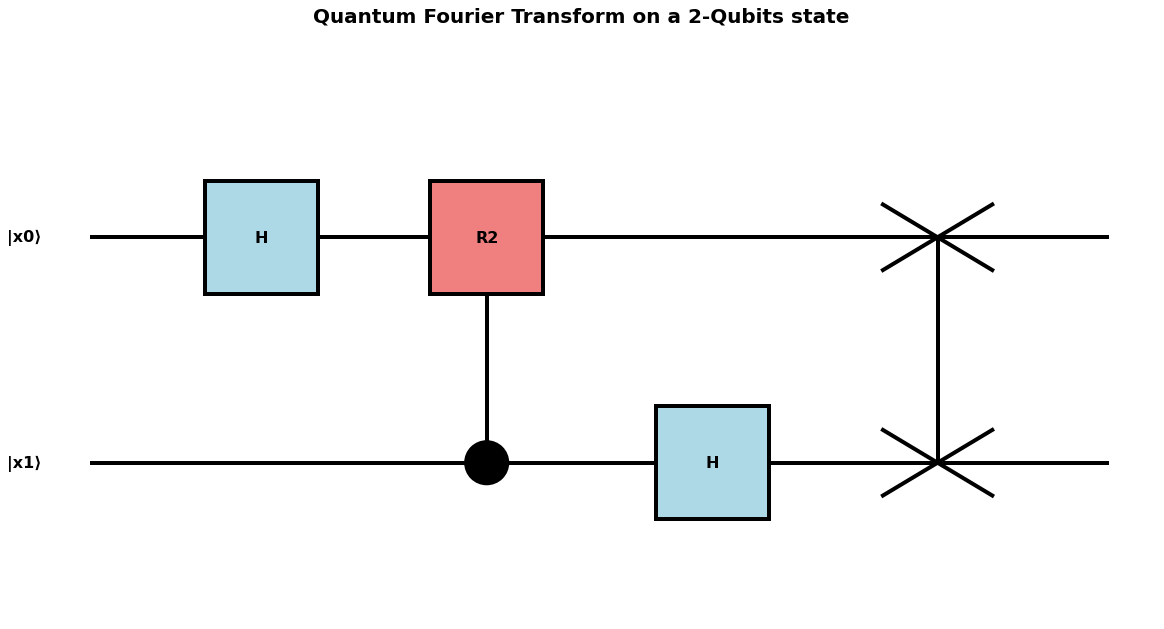

In [61]:
with Sketch(n_qubits=2, length=4, title='Quantum Fourier Transform on a 2-Qubits state') as s:
    s.add_hadamard(index=0, target=0)
    s.add_shift(index=1, control=1, target=0)
    s.add_hadamard(index=2, target=1)
    s.add_swap(index=3, targets=[1, 0])

Le dernier problème est que ces circuits ne sont que des schémas, ils n'effectuent aucune réelle opération sur les Qubits.

# 3 - Ajout des matrices correspondantes

Maintenant que la partie graphique est prête, il faut construire les représentations matricielles des portes quantiques pour un nombre fixé de Qubits. On va s'intéresser aux trois portes utiles pour construire un circuit QFT :
- la porte de Hadamard (qui n'agit que sur un Qubit)
- la porte de phase (qui agit sur deux Qubits)
- la porte $SWAP$ (qui agit sur deux Qubits)

Lorsque l'on applique une porte de Hadamard (de taille $2\times2$) à un état quantique de 3 Qubits (de taille $8\times1$), il faut ajuster la dimension au circuit. Pour cela, on place une matrice identité $I_2$ aux indices des Qubits non concernés et une matrice $H$ à l'indice du Qubit visé.

On rappelle $H = \frac{1}{\sqrt2} \begin{bmatrix}
1 & 1  \\
1 & -1 \\
\end{bmatrix}$.

Soit $H_n^{target}$ une porte de Hadamard appliquée au Qubit `target`. Pour un circuit de 3 Qubits et un Qubit visé 0, on a : $$H_3^0 = H \otimes I_2 \otimes I_2 = \begin{bmatrix}
I_2 &  & I_2 & \\
& I_2 & & I_2 \\
I_2 & & -I_2 & \\
& I_2 & & -I_2 \\
\end{bmatrix}$$

Similairement, $$H_3^1 = I_2 \otimes H \otimes I_2 = \begin{bmatrix}
I_2 & I_2 & & \\
I_2 & -I_2 & & \\
& & I_2 & I_2 \\
& & I_2 & -I_2 \\
\end{bmatrix}, H_3^2 = I_2 \otimes I_2 \otimes H = \begin{bmatrix}
H & & & \\
& H & & \\
& & H &  \\
& & & H \\
\end{bmatrix}$$.

On peut alors généraliser :
$$H_n^{target} =
\bigotimes_{k=0}^{n-1} \left\{
    \begin{array}{ll}
        H & \mbox{if } k = target \\
        I_2 & \mbox{else}
    \end{array}
\right.
$$

Il en vient la méthode `hadamard` de la classe `Circuit`, qui reprend ces éléments (avec la méthode `conk` qui correspond au produit de Kronecker consécutif d'une liste de matrices) :
```
def hadamard(self, target, inplace=True):
    matrix = self.conk([H.matrix if k is target else I2 for k in range(self.n_qubits)])
    self.matrices.append(matrix)
    self.gates.append(['hadamard', target])
    if not inplace:
        return self
```

Pour la porte de phase, le raisonnement est très similaire à deux différences près : d'abord il y a deux Qubits impliqués et la matrice équivalente s'exprime en deux parties.
Soient $R_m$ et $Z$ telles que :
$$R_m = \begin{bmatrix}
1 & 0 \\
0 & e^{2i \pi / 2^m} \\
\end{bmatrix},
Z = \begin{bmatrix}
1 & 0  \\
0 & -1 \\
\end{bmatrix}$$

Alors pour un circuit à 3 Qubits et $P_n^{\ control, target}$ la matrice de phase :
$$P_3^{1, 0} = I_2 \otimes \frac{I_2 + Z}{2} \otimes I_2 + R_2 \otimes \frac{I_2 - Z}{2} \otimes I_2$$

Et plus généralement on exprime la matrice comme un produit de Kronecker en deux parties :
$$P_n^{\ control, target} =
\bigotimes_{k=0}^{n-1} \left\{
    \begin{array}{ll}
        \frac{I_2 + Z}{2} & \mbox{if } k = control \\
        I_2 & \mbox{else}
    \end{array}
\right. +
\bigotimes_{k=0}^{n-1} \left\{
    \begin{array}{lll}
        R_{|control - target| + 1} & \mbox{if } k = target \\
        \frac{I_2 - Z}{2} & \mbox{if } k = control \\
        I_2 & \mbox{else}
    \end{array}
\right.
$$

Dans le code, on introduit les deux matrices $B_{00}$ et $B_{11}$ telles que :
$$B_{00} =
\frac{I_2 + Z}{2} =
\begin{pmatrix} 1&0\\ 0&0\\ \end{pmatrix}
\\
B_{11} =
\frac{I_2 - Z}{2} =
\begin{pmatrix} 0&0\\ 0&1\\ \end{pmatrix}$$

Enfin, la porte $SWAP$ se décompose classiquement comme suit :
$$SWAP = \frac{I \otimes I + X \otimes X + Y \otimes Y + Z \otimes Z}{2}$$

On la généralise donc comme précédemment :
$$SWAP_n^{targets} = \frac{1}{2} \times
\sum_{M \in \{I, X, Y, Z\}} \bigotimes_{k=0}^{n-1} \left\{
           \begin{array}{ll}
               M & \mbox{if } k \mbox{ in targets} \\
               I_2 & \mbox{else}
           \end{array}
       \right.
$$

Références :
- https://arxiv.org/pdf/2302.06377.pdf
- https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-fourier-transform.ipynb
- https://arxiv.org/pdf/2205.02525.pdf
- https://arxiv.org/pdf/quant-ph/9503016.pdf
- https://qudev.phys.ethz.ch/static/content/QSIT16/QSIT16_Super_L04_slides.pdf

Pour simplifier la syntaxe, la classe `Circuit` ne prend en argument que le nombre de Qubits. On peut ensuite appliquer les portes désirées, qui seront ajoutées dans l'ordre d'appel. Ici, on applique une porte de phase au Qubit $|x_0\rangle$ avec pour contrôle $|x_1\rangle$.

In [62]:
circuit3 = Circuit(n_qubits=3)
circuit3.shift(control=1, target=0)

On peut afficher le circuit résultant avec la méthode `draw`.

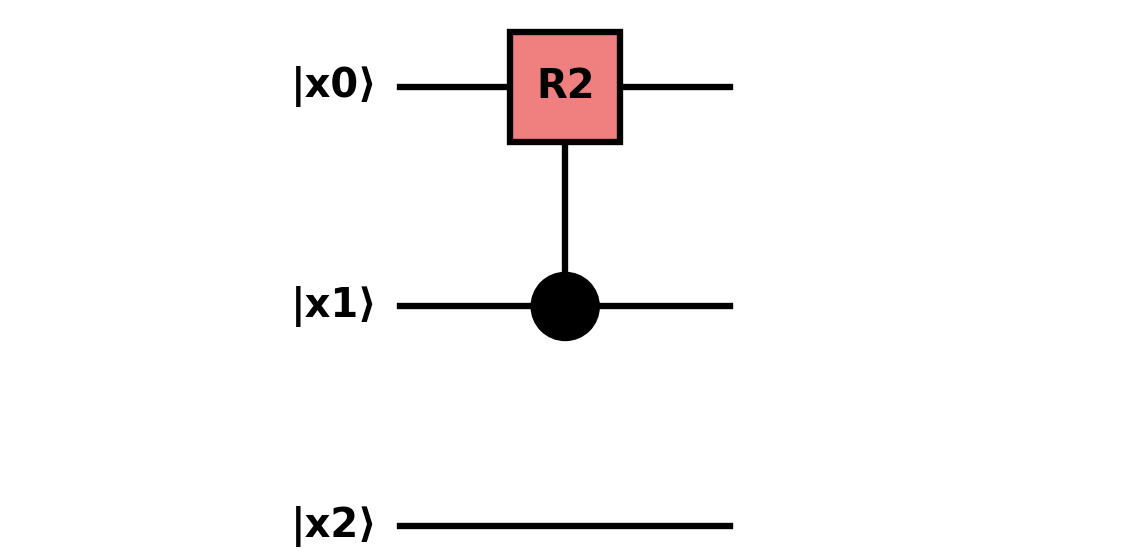

In [63]:
circuit3.draw()

On encore afficher la matrice équivalente au circuit, de taille $2^{\#qubits}$. On utilise implicitement la méthode `heatmap` qui renvoie les parties réelle et imaginaire de la matrice sous forme de heatmap.

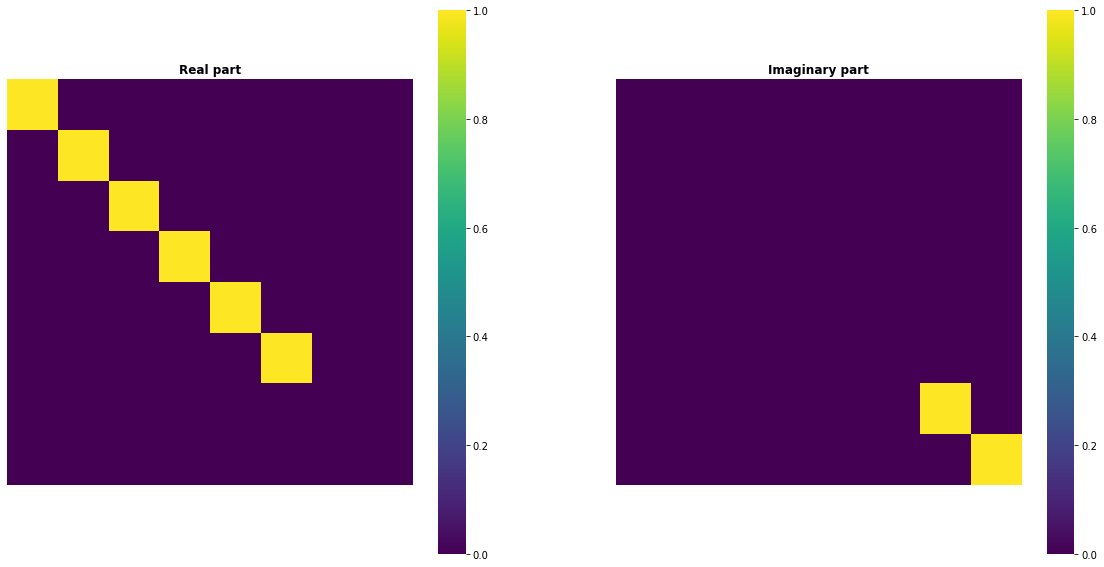

3-Qubits circuit

In [64]:
circuit3

On peut à nouveau construire des pseudo-circuits en utilisant les portes à notre disposition.

In [65]:
circuit5 = Circuit(5)
circuit5.hadamard(3)
circuit5.shift(0, 2)
circuit5.hadamard(1)
circuit5.swap(1, 4)

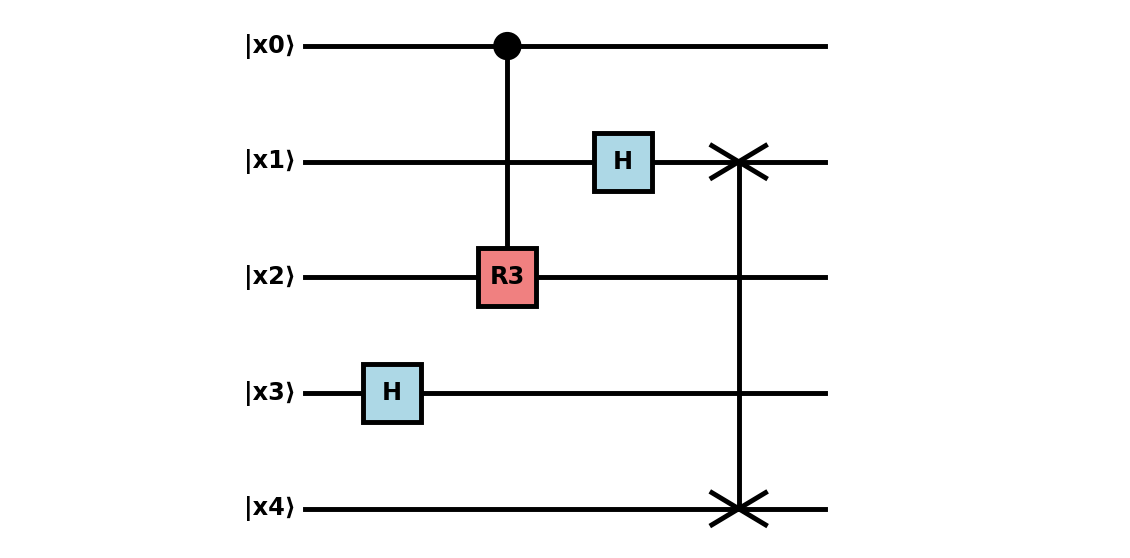

In [66]:
circuit5.draw()

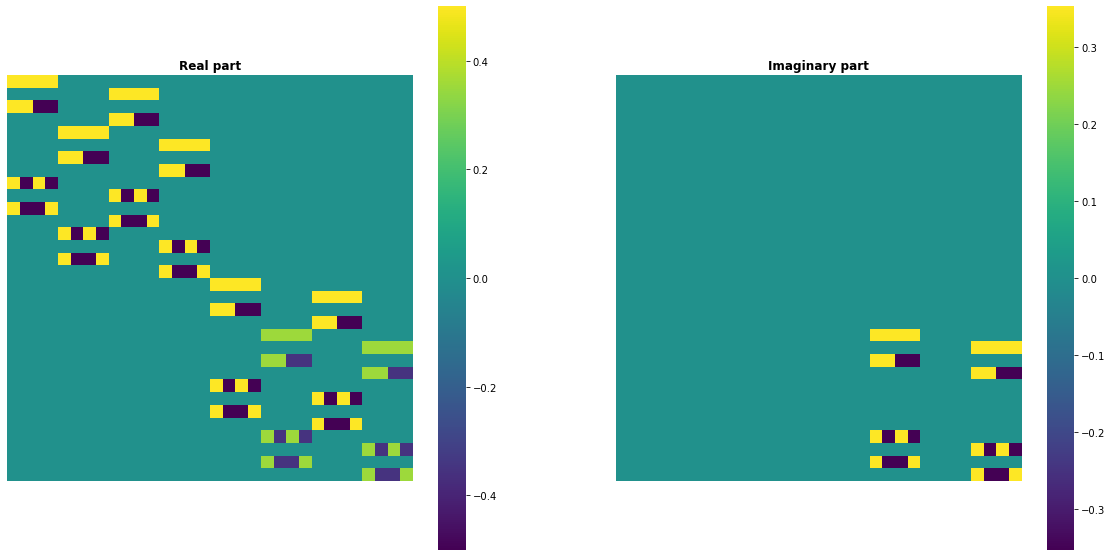

5-Qubits circuit

In [67]:
circuit5

Les différentes portes sont contenues dans l'attribut `gates` et sont ainsi facilement manipulables.

[['hadamard', 3], ['shift', 0, 2], ['hadamard', 1], ['swap', 1, 4]]
[['hadamard', 3], ['shift', 0, 2], ['swap', 1, 4]]


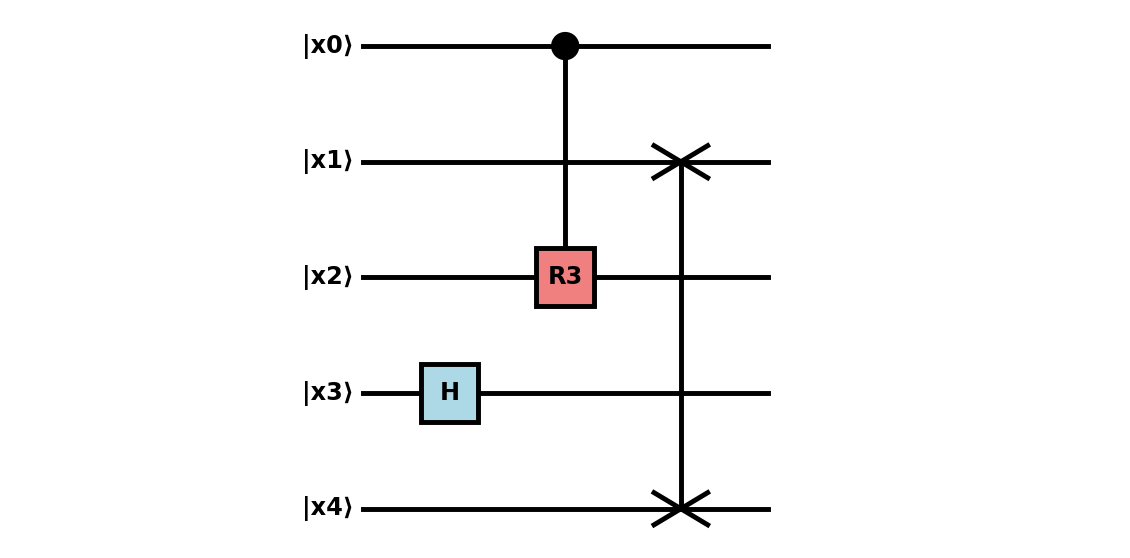

In [68]:
print(circuit5.gates)
circuit5.gates.pop(2)
print(circuit5.gates)
circuit5.draw()

On peut à présent utiliser ces nouveaux outils pour construire n'importe quel circuit correspondant à un algorithme utile en Information Quantique.